In [1]:
import cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob

from camera_calibration import read_calibration, undistort_image
from color_and_gradient import pipeline
from warp_perspective import read_warp, warp_image

import sys
sys.path.append('../')
from utils.plot_utils import plt_imlist

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Read params

In [2]:
int_params = read_calibration("intrinsics.p")
warp_params = read_warp("perspective.p")

In [3]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, ret_img=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    if ret_img is True:
        return left_fit, right_fit, out_img
    else:
        return  left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fit, right_fit

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
#result = search_around_poly(binary_warped)

In [4]:
def draw_lane(img, Minv, left_fit, right_fit):
    ploty = np.array(np.linspace(0, img.shape[0]-1, img.shape[0]))
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int32(pts), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result

In [5]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def update(self, fit):
        self.detected = True
        self.current_fit = fit 

In [6]:
class LaneFinder():
    def __init__(self):
        self.rlane = Line()
        self.llane = Line()
        self.int_params = read_calibration("intrinsics.p")
        self.warp_params = read_warp("perspective.p")
        self.warp_params_inv = np.linalg.inv(self.warp_params)
        
    def detected(self):
        return self.rlane.detected and self.llane.detected
    
    def undistort_image(self, img):
        return undistort_image(img, self.int_params)
    
    def threshold_image(self, img):
        return pipeline(img)
    
    def warp_image(self, img):
        return warp_image(img, self.warp_params)
        
    def process(self, img):
        img_rect = self.undistort_image(img)
        img_thresh = self.threshold_image(img_rect)
        img_warped = self.warp_image(img_thresh)
        if self.detected() is False:
            left_fit, right_fit = fit_polynomial(img_warped)
            print(left_fit, right_fit)
            self.llane.update(left_fit)
            self.rlane.update(right_fit)
            
        left_fit, right_fit = search_around_poly(img_warped, self.llane.current_fit, self.rlane.current_fit)
        self.llane.update(left_fit)
        self.rlane.update(right_fit)
        #plt.figure()
        return draw_lane(img_rect, self.warp_params_inv, self.llane.current_fit, self.rlane.current_fit)       

In [7]:
LF = LaneFinder()

images = glob.glob("test_images/**.jpg")

for image in images[-1:]:
    img = mpimg.imread(image)
    LF.process(img)

[ 8.24056334e-05 -8.37890038e-02  2.86205539e+02] [-1.16345354e-05 -1.57107013e-02  1.03739997e+03]


<Figure size 432x288 with 0 Axes>

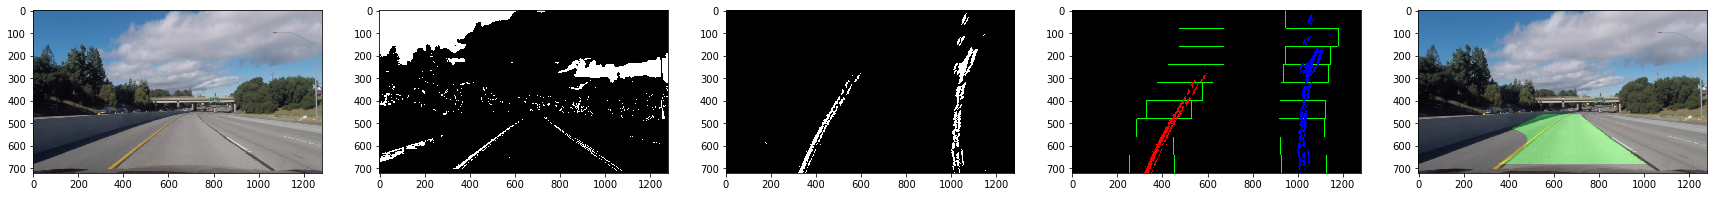

<Figure size 2160x1080 with 0 Axes>

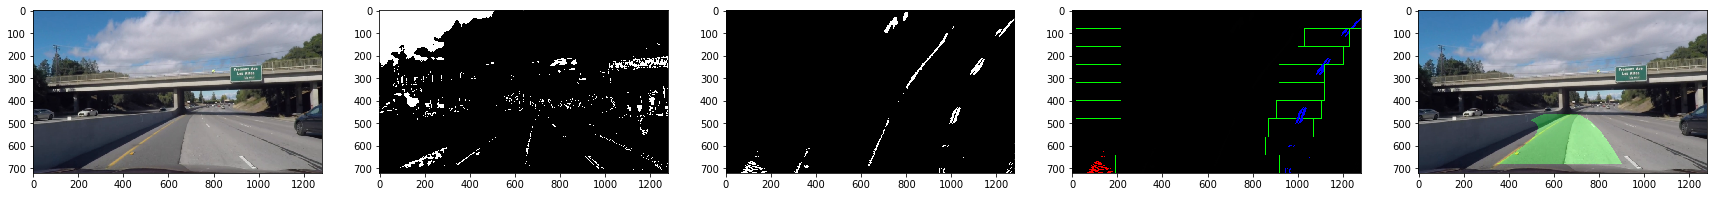

<Figure size 2160x1080 with 0 Axes>

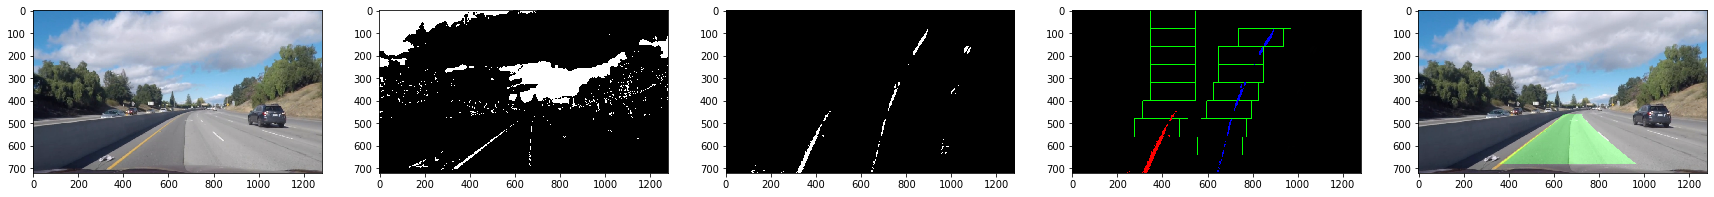

<Figure size 2160x1080 with 0 Axes>

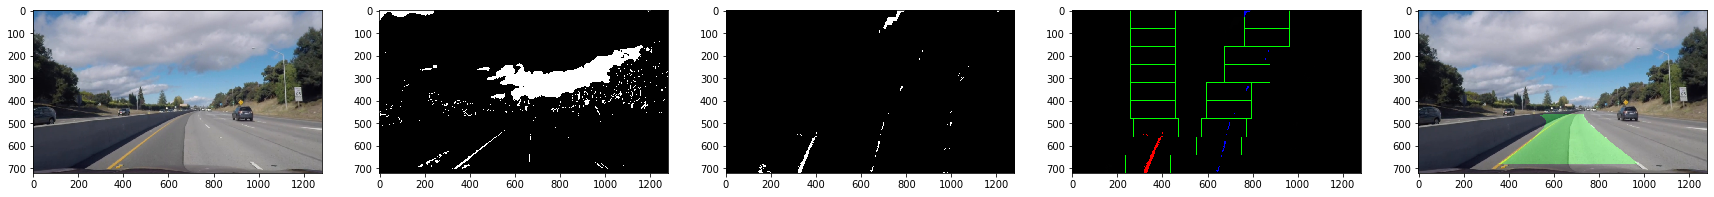

<Figure size 2160x1080 with 0 Axes>

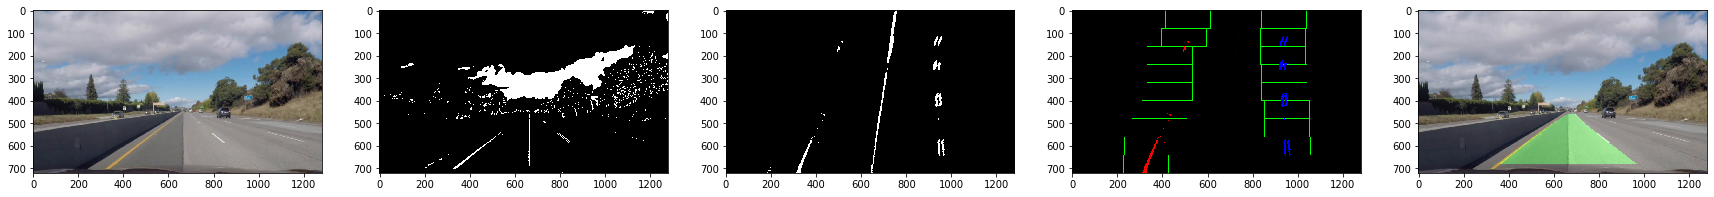

In [8]:
video = VideoFileClip('test_videos/challenge_video.mp4')

for i in range(5):
    img = video.get_frame(i*3)
    img_rect = LF.undistort_image(img)
    img_thresh = LF.threshold_image(img_rect)
    img_warped = LF.warp_image(img_thresh)
    _, _, out_img = fit_polynomial(img_warped, ret_img=True)
    ret = LF.process(img)
    plt_imlist([img_rect, img_thresh, img_warped, out_img, ret])

In [9]:
white_output = 'test_out.mp4'
clip1 = VideoFileClip("test_videos/challenge_video.mp4")
white_clip = clip1.fl_image(LF.process).subclip(0, 2)
%time white_clip.write_videofile(white_output, audio=False)

t:   5%|▌         | 3/60 [00:00<00:02, 23.35it/s, now=None]

Moviepy - Building video test_out.mp4.
Moviepy - Writing video test_out.mp4



Moviepy - Done !
Moviepy - video ready test_out.mp4
CPU times: user 4.52 s, sys: 866 ms, total: 5.38 s
Wall time: 3.83 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))